In [1]:
import numpy as np
import tensorflow as tf
#from tensorflow.keras.utils import to_categorical
from PIL import Image
import os
import pandas as pd
import math

import matplotlib.pyplot as plt

In [2]:
global dfO
dfO = pd.DataFrame(columns=["Time", "Res_Freq", "Amplitude", "Phase", "Sample_number", "Peak", "Before_compression", "After_compression", "Compression_ratio", "Compression_time"])

In [3]:
def reload_data(debug=False):
    #deep copy of dfO
    df = dfO.copy(deep=True)
    # for each sample in data_/Snail/<folder>/<name>.txt open the txt file and append the data to a pandas dataframe
    file_loaded = 0
    CompressionDict = {}

    for root, dirs, files in os.walk("/data_/Snail"):
        for name in files:
            if name.endswith(".txt"):
                file_path = os.path.join(root, name)
                sample_number = root.split("_")[-1]
                with open(file_path, "r") as f:
                    lines = f.readlines()
                
                file_loaded += 1

                header_index = lines.index("X_Value\tTime\tRes.Frequency\tAmplitude\tPhase\tComment\n")
                data_rows = lines[header_index+1:]

                data_values = [line.strip().split('\t')[:] for line in data_rows]
                #add the sample number to the data_values :
                # from [['0.050003', '1448.050731', '27.196000', '-5.780000'], ['0.150009', '1448.060841', '27.192000', '-5.720000'],..]
                # to [['0.050003', '1448.050731', '27.196000', '-5.780000', sample_number], ['0.150009', '1448.060841', '27.192000', '-5.720000', sample_number],..]
                #data_values = [row + [sample_number] for row in data_values]
                
                
                df_new = pd.DataFrame(data_values, columns=["Time", "Res_Freq", "Amplitude", "Phase"])

                df_new["Sample_number"] = sample_number
                df_new["Peak"] = 0
                df_new["Compression_time"] = 0

                df = pd.concat([df, df_new], ignore_index=True)

            if name.endswith(".tif"):
                if "before" in name:
                    # Get the 4 characters just before the string 'μm' and convert to float
                    Before_compression = float(name.split("μm")[0].split(" ")[-1])

                if name[0] == 'c':
                    # Get the characters between " " and "μm" and convert to float
                    After_compression = float(name.split("μm")[0].split(" ")[-1])

                    # Check if both "Before_compression" and "After_compression" values are non-zero
                    if Before_compression != 0 and After_compression != 0:
                        # Calculate the compression ratio
                        Compression_ratio = Before_compression / After_compression

                        # Get the sample_number from the root path
                        sample_number = root.split("_")[-1]

                        # Store the compression information in the CompressionDict
                        CompressionDict[sample_number] = {
                            "Before_compression": Before_compression,
                            "After_compression": After_compression,
                            "Compression_ratio": Compression_ratio
                        }
                        #print("CompressionDict: ", CompressionDict[sample_number])
        
        

           
    
    for key, value in CompressionDict.items():
            df.loc[df["Sample_number"] == key, "Before_compression"] = value["Before_compression"]
            df.loc[df["Sample_number"] == key, "After_compression"] = value["After_compression"]
            df.loc[df["Sample_number"] == key, "Compression_ratio"] = value["Compression_ratio"]


    df.astype({"Time": float, "Res_Freq": float, "Amplitude": float, "Phase": float, "Sample_number": int,
               "Peak": int, "Before_compression": int, "After_compression": int,
               "Compression_ratio": float, "Compression_time": float})
    
    df = df.apply(pd.to_numeric, errors='coerce')


    if debug:
        print("Files loaded: ", file_loaded)
        print("df shape: ", df.shape)
        # print("df head:\n",df.head())
    return df

df = reload_data(debug=False)
    



In [58]:
def drop_outliers(options_outliers:dict=None, debug=False):
    df = reload_data(debug)

    options_default = {"Res_Freq_min": 1000, "Res_Freq_max": 5000,
                "Amplitude_min": None, "Amplitude_max": 40,
                "Phase_min": None, "Phase_max": None,
                "interval_df" : [1350, 1600], "downsampling_rate" : 0.02}
    
    if options_outliers is not None:
        if debug: print("options received:" , options_outliers)
        for key in options_default.keys():
            if key in options_outliers.keys():
                options_default[key] = options_outliers[key]
        options_outliers = options_default
    else:
        options_outliers = options_default


    df = df.dropna()
    if debug: print("dfs-> dropna: ", df.shape)

    #drop duplicates
    df = df.drop_duplicates()
    if debug: print("dfs-> drop_duplicates: ", df.shape)


    #drop nan  in Res_Freq
    df = df[df.Res_Freq.notnull()]
    if debug: print(f"dfs-> dropna in Res_Freq: {df.shape}")

    

    # drop outliers in Res_Freq

    if options_outliers["Res_Freq_min"] is not None:
        df = df[df.Res_Freq > options_outliers["Res_Freq_min"]]
    if options_outliers["Res_Freq_max"] is not None:
        df = df[df.Res_Freq < options_outliers["Res_Freq_max"]]
        
    if debug: print(f"dfs-> outliers in Res_Freq [{options_outliers['Res_Freq_min']}:{options_outliers['Res_Freq_max']}] : {df.shape}")

    # drop outliers in Amplitude
    if options_outliers["Amplitude_min"] is not None:
        df = df[df.Amplitude > options_outliers["Amplitude_min"]]
    if options_outliers["Amplitude_max"] is not None:
        df = df[df.Amplitude < options_outliers["Amplitude_max"]]
    if debug: print(f"dfs-> outliers in Amplitude [{options_outliers['Amplitude_min']}:{options_outliers['Amplitude_max']}] : {df.shape}")

    # drop outliers in Phase
    if options_outliers["Phase_min"] is not None:
        df = df[df.Phase > options_outliers["Phase_min"]]
    if options_outliers["Phase_max"] is not None:
        df = df[df.Phase < options_outliers["Phase_max"]]
    if debug: print(f"dfs-> outliers in Phase [{options_outliers['Phase_min']}:{options_outliers['Phase_max']}] : {df.shape}")


    # reduce the number of data points in the interval [1350, 1600] of Res_Freq
    start = options_outliers["interval_df"][0]
    end = options_outliers["interval_df"][1]

    # Filter the dataframe to include values within the specified interval
    interval_df = df[(df['Res_Freq'] >= start) & (df['Res_Freq'] <= end)]

    downsampling_rate = options_outliers["downsampling_rate"]
    downsampled_df = interval_df.sample(frac=downsampling_rate, random_state=1)

    # interval_df = df[(df['Res_Freq'] >= 1500) & (df['Res_Freq'] <= 1200)]
    # downsampled_df = interval_df.sample(frac=0.02, random_state=1)

    df = pd.concat([df[~((df['Res_Freq'] >= start) & (df['Res_Freq'] <= end))], downsampled_df])

    if debug: print(f"dfs-> downsampling at {downsampling_rate*100}% in [{start}: {end}]: {df.shape}")
        

    #print max value of Res_Freq for each sample
    #print("max Res_Freq for each sample:\n", df.groupby("Sample_number")["Res_Freq"].max())
    return df

df = drop_outliers(debug=False, options_outliers=None)

In [5]:
def get_longest_peak_intrvl_Res_Freq(options_get_peak: dict = None, options_outliers: dict = None, debug=False):
    df = drop_outliers(options_outliers, debug)
    
    options_default = {"outlier_side_percent_on_longest_time_duration": 1.2,
                        "downsampling_factor_by_mean_value": 4,
                        "downsampling_rate": 1.2,
                        "number_of_interval_downsampling": 15,
                        "peak_freq": 1600}
    
    if options_get_peak is not None:
        if debug: print("options received:" , options_get_peak)
        for key in options_default.keys():
            if key in options_get_peak.keys():
                options_default[key] = options_get_peak[key]
        options_get_peak = options_default
    else:
        options_get_peak = options_default


    # isolate each peak of Res_Freq (the frequency needs to go below 1550 before going up again) for each sample
    for i in range(1, df["Sample_number"].max() + 1):
        df_sample = df[df["Sample_number"] == i]
        
        # Sort the values by time (type numpy.float64)
        df_sample = df_sample.sort_values(by="Time")

        
        # Find all the peaks
        peaks = []
        peak_start = None
        
        for j in range(1, len(df_sample) - 1):
            if df_sample["Res_Freq"].iloc[j] > options_get_peak["peak_freq"] and df_sample["Res_Freq"].iloc[j - 1] <= options_get_peak["peak_freq"]: #and df_sample["Res_Freq"].iloc[j + 1] >= 1550:
                if peak_start is None:
                    peak_start = df_sample["Time"].iloc[j]
                    # print(f"(>) Peak start: {peak_start} (Sample {i})")
            
            elif df_sample["Res_Freq"].iloc[j] <= options_get_peak["peak_freq"] and df_sample["Res_Freq"].iloc[j - 1] > options_get_peak["peak_freq"]:# and df_sample["Res_Freq"].iloc[j + 1] < 1550:
                if peak_start is not None:
                    # print(f"Peak end: {df_sample['Time'].iloc[j]} (Sample {i})")
                    peak_end = df_sample["Time"].iloc[j]
                    peaks.append([peak_start, peak_end])
                    peak_start = None
        
        #if debug: print(f"Peaks Sample {i}: {peaks}")

        #compressio_Time = addition of all the time between the start and end of each peak
        compression_Time = 0
        for peak in peaks:
            compression_Time += peak[1] - peak[0]
        if debug: print(f"Sample {i} - Compression time: {compression_Time}")
        # add it to the dataframe
        df.loc[df["Sample_number"] == i, "Compression_time"] = compression_Time

        # # Find the longest peak
        longest_peak = max(peaks, key=lambda p: p[1] - p[0]) if peaks else None

        # duration of the longest peak
        longest_peak_duration = 0
        if longest_peak:
            longest_peak_duration = longest_peak[1] - longest_peak[0]


        # Add 10 seconds before and after the longest peak
        if longest_peak:
            # get the rows of the longest peak (find the index the most close to the start and end of the peak +- 50 of the time of the peak (longest_peak_duration)) do not use options_get_peak["interval_scnd"] anymore
            start_time = df_sample.iloc[(df_sample["Time"] - longest_peak[0]
                                         +longest_peak_duration*options_get_peak["outlier_side_percent_on_longest_time_duration"]
                                         ).abs().argsort()[:1]].iloc[0]["Time"]
            end_time = df_sample.iloc[(df_sample["Time"] - longest_peak[1]
                                        -longest_peak_duration*options_get_peak["outlier_side_percent_on_longest_time_duration"]
                                        ).abs().argsort()[:1]].iloc[0]["Time"]
            if debug:
                print(f"Sample {i} - Longest peak: {longest_peak}, Interval: {start_time} - {end_time} (out of {len(peaks)} peaks)")
                # print number of values where peak == 1
            # Perform further operations with the interval
            # add Peak = 1 on df if the row is in the interval
            df.loc[(df["Sample_number"] == i) & (df["Time"] >= start_time) & (df["Time"] <= end_time), "Peak"] = 1





            # do interval of peak if to many values in interval compared to other do downsampling (change peak==0)
            # for 15 intervals
            values_per_interval = []
            # sort the values by Res_Freq
            df = df.sort_values(by="Res_Freq")
            # head

            #print only the rows where Peak == 1

            # get the difference between the max and min Res_Freq wher Peak == 1
            min_Res_Freq = df[(df["Peak"] == 1) & (df["Sample_number"] == i)]["Res_Freq"].min()
            max_Res_Freq = df[(df["Peak"] == 1) & (df["Sample_number"] == i)]["Res_Freq"].max()
            diff_Res_Freq = max_Res_Freq - min_Res_Freq
            if debug: print(f"Sample {i} - min_Res_Freq: {min_Res_Freq}, max_Res_Freq: {max_Res_Freq}, diff_Res_Freq: {diff_Res_Freq}")
            

            #cut the interval in options_get_peak["number_of_interval_downsampling"] intervals
            for k in range(0, options_get_peak["number_of_interval_downsampling"]):
                start = min_Res_Freq + diff_Res_Freq * (k - 1) / options_get_peak["number_of_interval_downsampling"]
                end = min_Res_Freq + diff_Res_Freq * k / options_get_peak["number_of_interval_downsampling"]
                #if debug: print(f"Sample {i} - Interval {k}: {start} - {end}")
                # get the number of values in the interval
                values_per_interval.append(len(df[(df["Peak"] == 1) & (df["Res_Freq"] >= start) & (df["Res_Freq"] <= end)]))



            if debug: print(f"Sample {i} - values_per_interval: {values_per_interval}")
            if debug: print(f"Sample {i} - total values in interval: {sum(values_per_interval)}")

            # get the mean of the values_per_interval
            mean_values_per_interval = sum(values_per_interval) / len(values_per_interval)
            if debug: print(f"Sample {i} - mean_values_per_interval: {mean_values_per_interval}")

            # if the number of values in the interval is more than 2 times the mean of the values_per_interval, do downsampling
            number_values_deleted = 0
            for k in range(0, len(values_per_interval)):
                #if debug: print(f"Sample {i} - Interval {k} ({start} - {end}) (values: {values_per_interval[k]}) (mean: {mean_values_per_interval})")
                if values_per_interval[k] > mean_values_per_interval*options_get_peak["downsampling_factor_by_mean_value"]:
                    iteration_to_delete = 0
                    if debug: print(f"Sample {i} - Downsampling interval {k} (values: {values_per_interval[k]}) (mean: {mean_values_per_interval})")
                    
                    # downsampling by options_get_peak["downsampling_rate"]. loop the var and if % downsample_rate != 0, set Peak = 0
                    start = min_Res_Freq + diff_Res_Freq * (k - 1) / options_get_peak["number_of_interval_downsampling"]
                    end = min_Res_Freq + diff_Res_Freq * k / options_get_peak["number_of_interval_downsampling"]
                    # for l in interval start to end len(df_sample[(df_sample["Peak"] == 1) & (df_sample["Res_Freq"] >= start) & (df_sample["Res_Freq"] <= end)]))
                    if debug: print(f"Sample {i} - Downsampling interval {k} - start: {start}, end: {end}")

                    current_line_debug_number_parce_que_les_lines_se_delete_jsp_pk = 0
                    for l in range(0, (values_per_interval[k]-1)):#-math.floor((values_per_interval[k]/options_get_peak["downsampling_rate"])))-1):
                        current_line = l - current_line_debug_number_parce_que_les_lines_se_delete_jsp_pk
                        try:
                            #print(f'number of row :  {len(df.loc[(df["Sample_number"] == i) & (df["Res_Freq"] >= start) & (df["Res_Freq"] <= end) & (df["Peak"] == 1)])}')
                            #print(f'PPRRERErow : {current_line}/{l} // {df.loc[(df["Sample_number"] == i) & (df["Res_Freq"] >= start) & (df["Res_Freq"] <= end) & (df["Peak"] == 1)].iloc[current_line]["Time"]}')
                            if math.floor(iteration_to_delete % options_get_peak["downsampling_rate"]) == 0:
                                time_row_to_delete = df.loc[(df["Sample_number"] == i) & (df["Res_Freq"] >= start) & (df["Res_Freq"] <= end) & (df["Peak"] == 1)].iloc[current_line]["Time"]
                                
                                #if debug: print(f"Peak number before delete is : Row of {time_row_to_delete} to delete: {df.loc[(df['Sample_number'] == i) & (df['Time'] == time_row_to_delete)]['Peak']}")
                                
                                #set Peak = 0
                                df.loc[(df["Sample_number"] == i) & (df["Time"] == time_row_to_delete), "Peak"] = 0   
                                number_values_deleted += 1
                                current_line_debug_number_parce_que_les_lines_se_delete_jsp_pk += 1

                                
                                #if debug: print(f"Peak number after delete is : Row of {time_row_to_delete} to delete: {df.loc[(df['Sample_number'] == i) & (df['Time'] == time_row_to_delete)]['Peak']}")
                            
                            iteration_to_delete += 1
                        except Exception as e:
                            if debug: print(f"Sample {i} - Downsampling interval {k} - error: {e}")

                    if debug: print(f"Sample {i} - Downsampling interval {k} - number of values deleted: {number_values_deleted}")
            if debug: print(f"Sample {i} - total values in interval after DS: {len(df[(df['Sample_number'] == i) & (df['Peak'] == 1)])}")
            

    return df

#df_peak = get_longest_peak_intrvl_Rez_Freq(interval_scnd=30, peak_freq=1550, options_outliers={"downsampling_rate": 1}, debug=False)
# pitié, ne pas toucher à cette fonction, elle est très fragile

In [6]:
def get_df(option_get_df: dict=None, options_get_peak: dict=None, options_outliers: dict=None, debug=False):

    options_default = {"type": None}
    
    if option_get_df is not None:
        if debug: print("options received:" , option_get_df)
        for key in options_default.keys():
            if key in option_get_df.keys():
                options_default[key] = option_get_df[key]
        option_get_df = options_default
    else:
        option_get_df = options_default

    if option_get_df["type"] == "raw":
        df = drop_outliers(options_outliers, debug)

    elif option_get_df["type"] == "peak":
        df = get_longest_peak_intrvl_Res_Freq(options_get_peak,
                                                options_outliers,
                                                debug)
    else:
        df = get_longest_peak_intrvl_Res_Freq(options_get_peak,
                                                options_outliers,
                                                debug)

    return df

In [60]:
# save df
def save_df(df, name):
    df.to_csv(name, index=False)

#df = get_df(option_get_df={"type":"raw"}, options_outliers={"downsampling_rate": 0.6}, debug=True)
# df = get_df(options_get_peak={"outlier_side_percent_on_longest_time_duration": 1.4,
#                         "downsampling_factor_by_mean_value": 5,
#                         "downsampling_rate": 1.1,
#                         "number_of_interval_downsampling": 15,
#                         "peak_freq": 1550})

df = get_df(option_get_df={"type":None}, options_outliers={"Res_Freq_min": None, "Res_Freq_max": 4045,
                "Amplitude_min": 1, "Amplitude_max": 30,
                "Phase_min": None, "Phase_max": None,
                "interval_df" : [1000, 1650], "downsampling_rate" : 0.02, "downsampling_ampli_min": 20},
                
            options_get_peak = {"outlier_side_percent_on_longest_time_duration": 1.5,
                "downsampling_factor_by_mean_value": 3,
                "downsampling_rate": 1.1,
                "number_of_interval_downsampling": 15,
                "peak_freq": 1600}
                
    
                        )


# df = get_df(option_get_df={"type":"raw"})

save_df(df, '/data_/cleaned_data.csv')





options_get_peak = {"outlier_side_percent_on_longest_time_duration": 1.2,
                        "downsampling_factor_by_mean_value": 4,
                        "downsampling_rate": 1.2,
                        "number_of_interval_downsampling": 15,
                        "peak_freq": 1600}

options_outliers = {"Res_Freq_min": 1000, "Res_Freq_max": 5000,
                "Amplitude_min": None, "Amplitude_max": 20,
                "Phase_min": None, "Phase_max": None,
                "interval_df" : [1350, 1600], "downsampling_rate" : 0.02}


In [8]:
def plot_data_repartition(df=False, options_plot=None, 
                                       option_get_peak: dict = None,
                                       options_outliers: dict = None, debug=False,):
    options_default = {"type": None, "sample": "all", "width": 0, "height": 0, "bins": 15}
    
    if options_plot is not None:
        if debug: print("options received:" , options_plot)
        for key in options_default.keys():
            if key in options_plot.keys():
                options_default[key] = options_plot[key]
        options_plot = options_default
    else:
        options_plot = options_default


    # if df is not provided, reload the data (if type != false)
    if type(df) != pd.DataFrame:
        option_get_df = {"type": None}

        if options_plot["type"] == "raw":
            option_get_df["type"] = "raw"   
        
        #downsampling_rate
        dsr = options_outliers["downsampling_rate"] if options_outliers is not None else 0.2
        df = get_df(option_get_df, option_get_peak, options_outliers, debug)

    # if sample is not all, select the sample
    if options_plot["sample"] != "all":
        df = df[df["Sample_number"] == options_plot["sample"]]


    if options_plot["type"] == "all":
        plt.hist(df["Res_Freq"], bins=options_plot["bins"])
        plt.hist(df[df["Peak"] == 1]["Res_Freq"], bins=options_plot["bins"])
        plt.legend([f"raw DSR {dsr}", "Peak"])

    elif options_plot["type"] == "raw":
        plt.hist(df["Res_Freq"], bins=options_plot["bins"]) 
        plt.legend([f"raw DSR {dsr}"])
    
    elif options_plot["type"] == "peak":
        plt.hist(df[df["Peak"] == 1]["Res_Freq"], bins=options_plot["bins"])
        plt.legend(["Peak"])  

    # Set labels for x-axis and y-axis
    plt.xlabel("Res_Freq")
    plt.ylabel("Number of values")

    # Set a title for the plot
    plt.title("Histogram of Res_Freq")

    # add legend

    # Display the plot
    plt.show()


# plot_data_repartition(options_plot={"type": "peak", "sample": 9},
#                       option_get_peak={"outlier_side_percent_on_longest_time_duration": 1},
#                       debug=False)

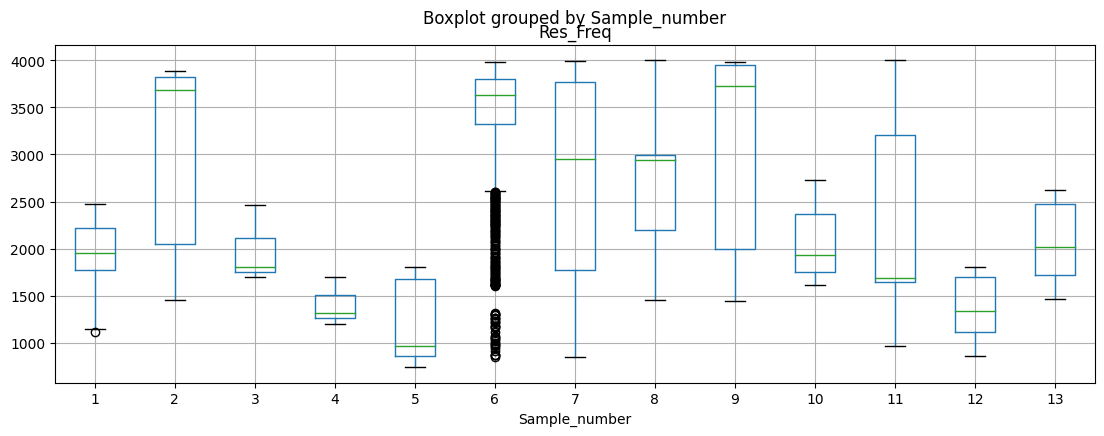

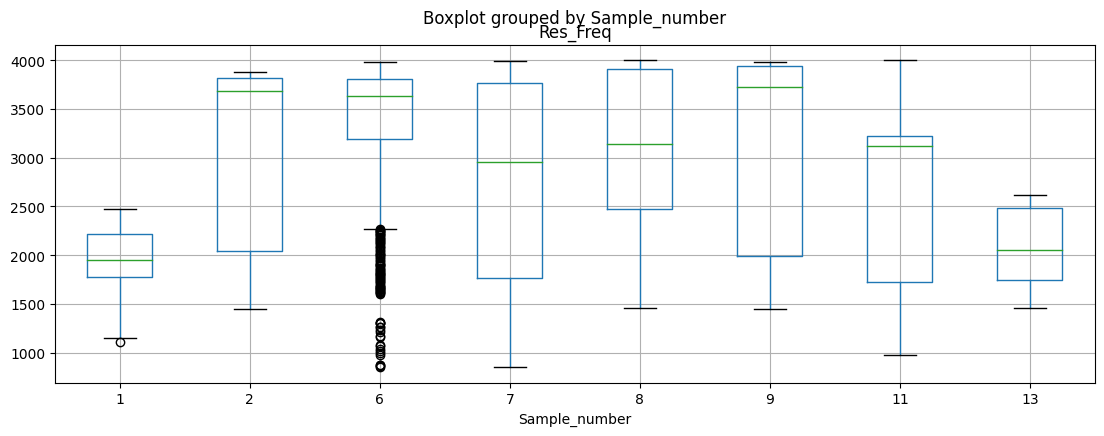

In [9]:
def plot_boxplot(column_to_plot:list, df=False, options_plot=None, 
                                       options_get_peak: dict = None,
                                       options_outliers: dict = None, debug=False,):
    options_default = {"type": None, "width": 13, "height": 4.5}
    
    if options_plot is not None:
        if debug: print("options received:" , options_plot)
        for key in options_default.keys():
            if key in options_plot.keys():
                options_default[key] = options_plot[key]
        options_plot = options_default
    else:
        options_plot = options_default


    # if df is not provided, reload the data (if type != false)
    if type(df) != pd.DataFrame:
        option_get_df = {"type": None}

        if options_plot["type"] == "raw":
            option_get_df["type"] = "raw"   
            df_raw = get_df(option_get_df, options_get_peak, options_outliers, debug)
        
        elif options_plot["type"] == "peak":
            df_peak = get_df(option_get_df, options_get_peak, options_outliers, debug)
        
        else:
            df_peak = get_df(option_get_df, options_get_peak, options_outliers, debug)
            
            option_get_df["type"] = "raw"   
            df_raw = get_df(option_get_df, options_get_peak, options_outliers, debug)


    if options_plot["type"] == "all":
        df_raw.boxplot(column=column_to_plot, by="Sample_number", figsize=(options_plot["width"], options_plot["height"]))
        df_peak[df_peak["Peak"] == 1].boxplot(column=column_to_plot, by="Sample_number", figsize=(options_plot["width"], options_plot["height"]))

    elif options_plot["type"] == "raw":
        df_raw.boxplot(column=column_to_plot, by="Sample_number", figsize=(options_plot["width"], options_plot["height"]))

    elif options_plot["type"] == "peak":
        df_peak[df_peak["Peak"] == 1].boxplot(column=column_to_plot, by="Sample_number", figsize=(options_plot["width"], options_plot["height"]))



plot_boxplot(["Res_Freq"], options_plot={"type": "all"},
             options_outliers={"Res_Freq_min": None, "Res_Freq_max": 4000,
                "Amplitude_min": None, "Amplitude_max": 20,
                "Phase_min": None, "Phase_max": None,
                "interval_df" : [1350, 1600], "downsampling_rate" : 0.02},
                
                
                options_get_peak = {"outlier_side_percent_on_longest_time_duration": 2,
                        "downsampling_factor_by_mean_value": 4,
                        "downsampling_rate": 1.2,
                        "number_of_interval_downsampling": 15,
                        "peak_freq": 1600},
             debug=False)



In [10]:
#df.plot.scatter(x="Time", y="Res_Freq", c="Sample_number", colormap="viridis")
# plot only for one sample
#df[df["Sample_number"] == 1].plot.scatter(x="Time", y="Res_Freq")

def plot_time_vs_Res_Freq_vs_Amplitude(sample_numbers=False, df=False, options_plot=None, 
                                       option_get_peak: dict = None,
                                       options_outliers: dict = None, debug=False,):
    options_default = {"type": None, "width": 8, "height": 3}
    
    if options_plot is not None:
        if debug: print("options received:" , options_plot)
        for key in options_default.keys():
            if key in options_plot.keys():
                options_default[key] = options_plot[key]
        options_plot = options_default
    else:
        options_plot = options_default



    # if df is not provided, reload the data (if type != false)
    if type(df) != pd.DataFrame:
        option_get_df = {"type": None}

        if options_plot["type"] == "raw":
            option_get_df["type"] = "raw"   
            
        df = get_df(option_get_df, option_get_peak, options_outliers, debug)
    

    if not sample_numbers:
        sample_numbers = [1]
        
    num_samples = len(sample_numbers)
    fig, axs = plt.subplots(num_samples, 1, figsize=(options_plot["width"], options_plot["height"]*num_samples))  # Adjust the figsize parameter for smaller size

    for i, sample_number in enumerate(sample_numbers):
        # deep copy of the dataframe
        df_copy = df.copy()
        # Drop outliers and filter the dataframe based on the sample_number
        df_sample = df_copy[df_copy["Sample_number"] == sample_number]

        if options_plot["type"] == "peak":
            df_sample = df_sample[df_sample["Peak"] == 1]
            

        # if no data print then pass to next sample

        if df_sample.shape[0] == 0:
            print(f"No data for sample for: {sample_number}")
            continue
            
        
        # Extract the relevant columns
        time = df_sample["Time"]
        res_freq = df_sample["Res_Freq"]
        amplitude = df_sample["Amplitude"]

        

        # Sort the values of time
        time, res_freq, amplitude = zip(*sorted(zip(time, res_freq, amplitude)))

        # Plot the lines on separate subplots
        ax = axs[i] if num_samples > 1 else axs  # Use the respective subplot
        color1 = 'tab:red'
        ax.plot(time, res_freq, color=color1, label="Freq (s{})".format(sample_number))
        ax.set_xlabel("Time")
        ax.set_ylabel("Frequency", color=color1)
        ax.tick_params(axis='y', labelcolor=color1)
        ax.legend(loc="upper left")

        ax2 = ax.twinx()  # Create a separate y-axis for amplitude
        color2 = 'tab:blue'
        ax2.plot(time, amplitude, color=color2, label="Amp (s{})".format(sample_number))
        ax2.set_ylabel("Amplitude", color=color2)
        ax2.tick_params(axis='y', labelcolor=color2)
        ax2.legend(loc="upper right")

    # Set a common title for the plot
    title = "Time vs Frequency vs Amplitude"
    if options_plot["type"]:
        title += f" ({options_plot['type']})"
    fig.suptitle(title)

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Display the plot
    plt.show()
    
    

#plot_time_vs_Res_Freq_vs_Amplitude([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
#plot_time_vs_Res_Freq_vs_Amplitude([4], debug=True, options_outliers={"Res_Freq_min": None, "Res_Freq_max": None, "Amplitude_max": None, "downsampling_rate": 0.1})




In [11]:
def plot_compression_time(df=False, option_get_peak: dict = None,
                            options_outliers: dict = None, debug=False):


    # if df is not provided, reload the data (if type != false)
    if type(df) != pd.DataFrame:
        option_get_df = {"type": "peak"}
        df = get_df(option_get_df, option_get_peak, options_outliers, debug)
    
    # take one Compression_time for each sample
    df = df.groupby("Sample_number").first().reset_index()
    df = df[["Sample_number", "Compression_time"]]
    df = df.sort_values(by="Sample_number")

    # plot
    plt.plot(df["Sample_number"], df["Compression_time"])
    plt.xlabel("Sample number")
    plt.ylabel("Compression time")
    plt.title("Compression time vs Sample number")
    plt.show()
    

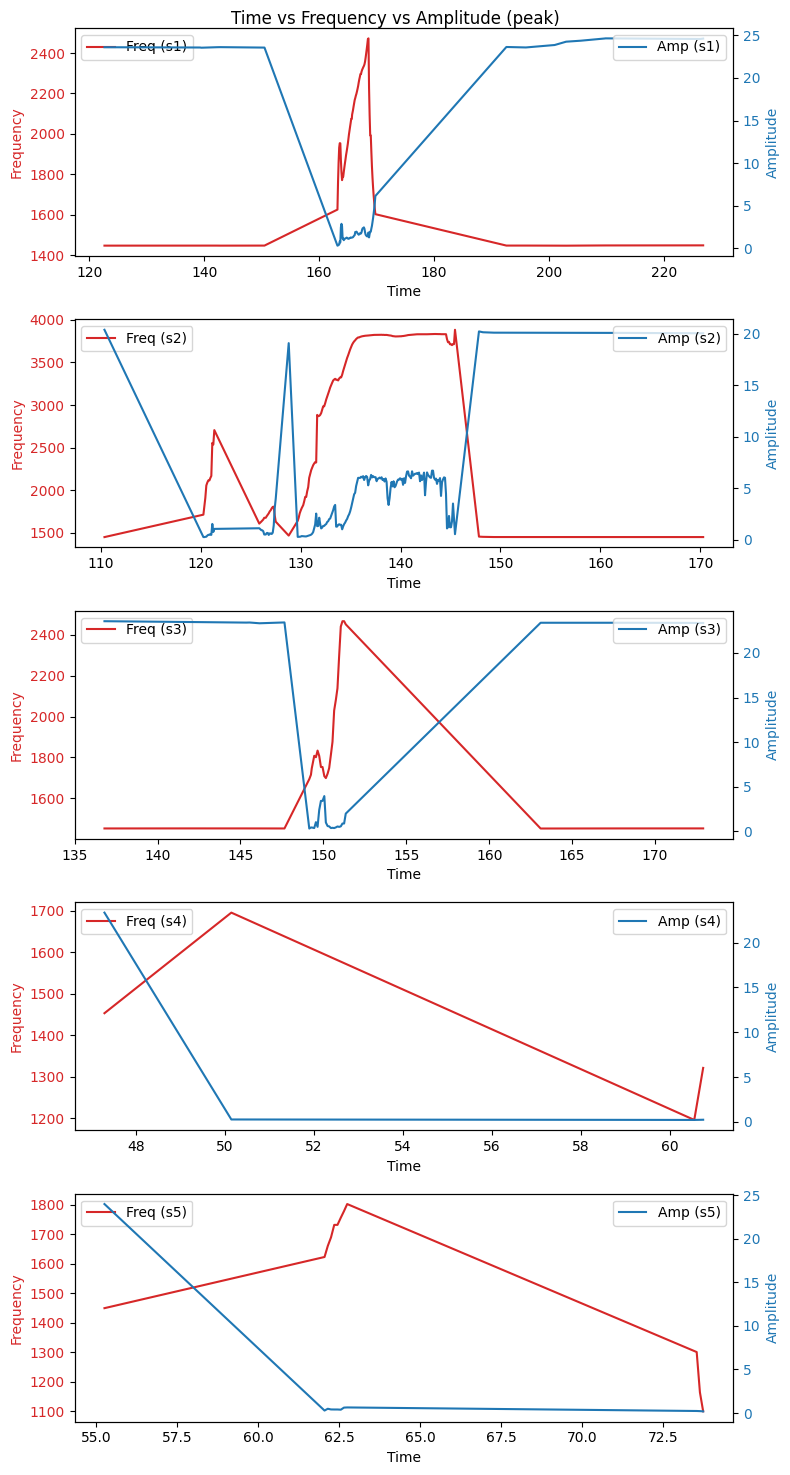

In [23]:

df_peak = get_df(option_get_df={"type": "peak"})

graph_to_plot = [1,2,3,4, 5]
# plot_time_vs_Res_Freq_vs_Amplitude(graph_to_plot, options_plot={"type" : "raw"})
plot_time_vs_Res_Freq_vs_Amplitude(graph_to_plot, options_plot= {"type" : "peak"},    
                        )

# plot_compression_time(df=df_peak)

options received: {'type': 'peak', 'sample': 13, 'bins': 10}
options received: {'type': None}
Files loaded:  14
df shape:  (179886, 10)
dfs-> dropna:  (169086, 10)
dfs-> drop_duplicates:  (169086, 10)
dfs-> dropna in Res_Freq: (169086, 10)
dfs-> outliers in Res_Freq [1000:5000] : (169051, 10)
dfs-> outliers in Amplitude [None:40] : (169031, 10)
dfs-> outliers in Phase [None:None] : (169031, 10)
dfs-> downsampling at 2.0% in [1350: 1600]: (10422, 10)
options received: {'number_of_interval_downsampling': 1}
Sample 1 - Compression time: 75.69932999999995
Sample 1 - Longest peak: [163.200335, 192.600016], Interval: 122.650015 - 226.849975 (out of 4 peaks)
Sample 1 - min_Res_Freq: 1447.314939, max_Res_Freq: 2472.599757, diff_Res_Freq: 1025.2848179999999
Sample 1 - values_per_interval: [1]
Sample 1 - total values in interval: 1
Sample 1 - mean_values_per_interval: 1.0
Sample 1 - total values in interval after DS: 86
Sample 2 - Compression time: 26.69352699999999
Sample 2 - Longest peak: [129

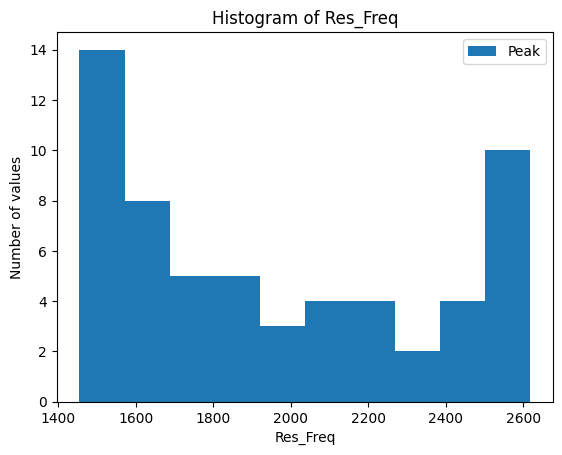

options received: {'type': 'peak', 'sample': 13, 'bins': 10}
options received: {'type': None}
Files loaded:  14
df shape:  (179886, 10)
dfs-> dropna:  (169086, 10)
dfs-> drop_duplicates:  (169086, 10)
dfs-> dropna in Res_Freq: (169086, 10)
dfs-> outliers in Res_Freq [1000:5000] : (169051, 10)
dfs-> outliers in Amplitude [None:40] : (169031, 10)
dfs-> outliers in Phase [None:None] : (169031, 10)
dfs-> downsampling at 2.0% in [1350: 1600]: (10422, 10)
Sample 1 - Compression time: 75.69932999999995
Sample 1 - Longest peak: [163.200335, 192.600016], Interval: 122.650015 - 226.849975 (out of 4 peaks)
Sample 1 - min_Res_Freq: 1447.314939, max_Res_Freq: 2472.599757, diff_Res_Freq: 1025.2848179999999
Sample 1 - values_per_interval: [1, 19, 0, 3, 2, 6, 5, 6, 8, 4, 5, 6, 5, 8, 5]
Sample 1 - total values in interval: 83
Sample 1 - mean_values_per_interval: 5.533333333333333
Sample 1 - total values in interval after DS: 86
Sample 2 - Compression time: 26.69352699999999
Sample 2 - Longest peak: [12

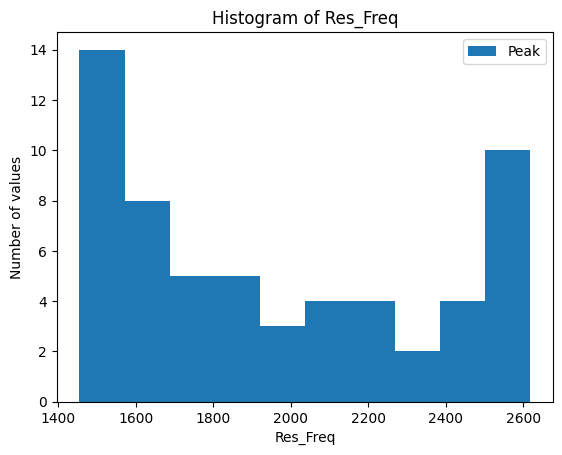

In [13]:

truc_plot = 13
# plot histogram of sample 9
plot_data_repartition(options_plot={"type": "peak", "sample": truc_plot, "bins": 10},
                      option_get_peak={"number_of_interval_downsampling": 1},
                      debug=True
                      )

# plot histogram of sample 9
plot_data_repartition(options_plot={"type": "peak", "sample": truc_plot, "bins": 10},
                      debug=True)





In [14]:
# display After_compression and Before_compression number for each sample
print(df.groupby("Sample_number")["After_compression"].max())

                                  

Sample_number
1     11.8
2     11.8
3     11.2
5     11.2
6     11.2
7     11.3
8     11.2
9     10.3
10    10.3
11    11.3
12    11.8
13    11.8
Name: After_compression, dtype: float64


In [15]:
print(float("before comp 14μm".split("μm")[0].split(" ")[-1]))
print(float("before comp 14.58μm".split("μm")[0].split(" ")[-1]))

14.0
14.58


In [16]:
def get_before_compression():
    #display each sample with the before compression value
    # there is only one value for each sample
    for i in range(1, df["Sample_number"].max() + 1):
        df_sample = df[df["Sample_number"] == i]
        print(f"Sample {i} - Before compression: {df_sample['Before_compression'].iloc[0]}")

get_before_compression()

Sample 1 - Before compression: 14.6
Sample 2 - Before compression: 14.5
Sample 3 - Before compression: 13.8


IndexError: single positional indexer is out-of-bounds